## Loading of Steinmetz data

includes some visualizations

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.decomposition import PCA

import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

from torchvision.utils import make_grid
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, TensorDataset

from tqdm.auto import tqdm
from IPython.display import display


In [ ]:
def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("GPU is not enabled in this notebook. \n"
          "If you want to enable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `GPU` from the dropdown menu")
  else:
    print("GPU is enabled in this notebook. \n"
          "If you want to disable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `None` from the dropdown menu")

  return device

In [ ]:
# @title Set random seed

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# For DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [ ]:
SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 2021 has been set.
GPU is not enabled in this notebook. 
If you want to enable it, in the menu under `Runtime` -> 
`Hardware accelerator.` and select `GPU` from the dropdown menu


In [ ]:
# @title Helper functions (MLP Tutorial 1 Codes)

# @markdown `Net(nn.Module)`

class Net(nn.Module):
  """
  Simulate MLP Network
  """

  def __init__(self, actv, input_feature_num, hidden_unit_nums, output_feature_num):
    """
    Initialize MLP Network parameters

    Args:
      actv: string
        Activation function
      input_feature_num: int
        Number of input features
      hidden_unit_nums: int
        Number of units in the hidden layer
      output_feature_num: int
        Number of output features

    Returns:
      Nothing
    """
    super(Net, self).__init__()
    self.input_feature_num = input_feature_num # Save the input size for reshapinng later
    self.mlp = nn.Sequential() # Initialize layers of MLP

    in_num = input_feature_num # Initialize the temporary input feature to each layer
    for i in range(len(hidden_unit_nums)): # Loop over layers and create each one
      out_num = hidden_unit_nums[i] # Assign the current layer hidden unit from list
      layer = nn.Linear(in_num, out_num) # Use nn.Linear to define the layer
      in_num = out_num # Assign next layer input using current layer output
      self.mlp.add_module(f"Linear_{i}", layer) # Append layer to the model with a name

      actv_layer = eval(f"nn.{actv}") # Assign activation function (eval allows us to instantiate object from string)
      self.mlp.add_module(f"Activation_{i}", actv_layer) # Append activation to the model with a name

    out_layer = nn.Linear(in_num, output_feature_num) # Create final layer
    self.mlp.add_module('Output_Linear', out_layer) # Append the final layer

  def forward(self, x):
    """
    Simulate forward pass of MLP Network

    Args:
      x: torch.tensor
        Input data

    Returns:
      logits: Instance of MLP
        Forward pass of MLP
    """
    # Reshape inputs to (batch_size, input_feature_num)
    # Just in case the input vector is not 2D, like an image!
    x = x.view(-1, self.input_feature_num)

    logits = self.mlp(x) # forward pass of MLP
    return logits


# @markdown `train_test_classification(net, criterion, optimizer, train_loader, test_loader, num_epochs=1, verbose=True, training_plot=False)`
def train_test_classification(net, criterion, optimizer, train_loader,
                              test_loader, num_epochs=1, verbose=True,
                              training_plot=True, device='cpu'):
  """
  Accumulate training loss/Evaluate performance

  Args:
    net: Instance of Net class
      Describes the model with ReLU activation, batch size 128
    criterion: torch.nn type
      Criterion combines LogSoftmax and NLLLoss in one single class.
    optimizer: torch.optim type
      Implements Adam algorithm.
    train_loader: torch.utils.data type
      Combines the train dataset and sampler, and provides an iterable over the given dataset.
    test_loader: torch.utils.data type
      Combines the test dataset and sampler, and provides an iterable over the given dataset.
    num_epochs: int
      Number of epochs [default: 1]
    verbose: boolean
      If True, print statistics
    training_plot=False
      If True, display training plot
    device: string
      CUDA/GPU if available, CPU otherwise

  Returns:
    Nothing
  """
  net.to(device)
  net.train()
  training_losses = []
  for epoch in tqdm(range(num_epochs)):  # Loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
      # Get the inputs; data is a list of [inputs, labels]
      inputs, labels = data
      inputs = inputs.to(device).float()
      labels = labels.to(device).long()

      # Zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = net(inputs)

      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      # Print statistics
      if verbose:
        training_losses += [loss.item()]

  net.eval()

  def test(data_loader):
    """
    Function to gauge network performance

    Args:
      data_loader: torch.utils.data type
        Combines the test dataset and sampler, and provides an iterable over the given dataset.

    Returns:
      acc: float
        Performance of the network
      total: int
        Number of datapoints in the dataloader
    """
    correct = 0
    total = 0
    for data in data_loader:
      inputs, labels = data
      inputs = inputs.to(device).float()
      labels = labels.to(device).long()

      outputs = net(inputs)
      _, predicted = torch.max(outputs, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    return total, acc

  train_total, train_acc = test(train_loader)
  test_total, test_acc = test(test_loader)

  if verbose:
    print(f'\nAccuracy on the {train_total} training samples: {train_acc:0.2f}')
    print(f'Accuracy on the {test_total} testing samples: {test_acc:0.2f}\n')

  if training_plot:
    plt.plot(training_losses)
    plt.xlabel('Batch')
    plt.ylabel('Training loss')
    plt.show()

  return train_acc, test_acc


# @markdown `shuffle_and_split_data(X, y, seed)`
def shuffle_and_split_data(X, y, seed):
  """
  Helper function to shuffle and split data

  Args:
    X: torch.tensor
      Input data
    y: torch.tensor
      Corresponding target variables
    seed: int
      Set seed for reproducibility

  Returns:
    X_test: torch.tensor
      Test data [20% of X]
    y_test: torch.tensor
      Labels corresponding to above mentioned test data
    X_train: torch.tensor
      Train data [80% of X]
    y_train: torch.tensor
      Labels corresponding to above mentioned train data
  """
  # Set seed for reproducibility
  torch.manual_seed(seed)
  # Number of samples
  N = X.shape[1]
  # Shuffle data
  shuffled_indices = torch.randperm(N)   # Get indices to shuffle data, could use torch.randperm
  X = X[:,shuffled_indices]
  y = y[shuffled_indices]

  # Split data into train/test
  test_size = int(0.2 * N)    # Assign test datset size using 20% of samples
  X_test = X[:,:test_size]
  y_test = y[:test_size]
  X_train = X[:,test_size:]
  y_train = y[test_size:]

  return X_test, y_test, X_train, y_train

In [ ]:
X = torch.from_numpy(dat['spks']);
dat['response'][dat['response'] == -1] = 2
y = torch.from_numpy(dat['response']); # responses is just one of multiple options for animals's behaivors,


In [ ]:
X_temp = torch.empty(X.shape[0] * X.shape[2], X.shape[1])
for i in range(X.shape[1]):
    X_temp[:,i] = X[:, i,:].flatten()


In [ ]:
X_temp.shape

torch.Size([174500, 340])

In [ ]:
X_test, y_test, X_train, y_train = shuffle_and_split_data(X_temp, y, seed=SEED)


In [ ]:
X_test.shape

torch.Size([174500, 68])

In [ ]:
y_test.shape

torch.Size([68])

In [ ]:
X_train.shape

torch.Size([174500, 272])

In [ ]:
y_train.shape

torch.Size([272])

In [ ]:

# DataLoader with random seed
batch_size = 64
g_seed = torch.Generator()
g_seed.manual_seed(SEED)

test_data = TensorDataset(X_test.T, y_test)
test_loader = DataLoader(test_data, batch_size=batch_size,
                         shuffle=False, num_workers=0,
                         worker_init_fn=seed_worker,
                         generator=g_seed,
                         )

train_data = TensorDataset(X_train.T, y_train)
train_loader = DataLoader(train_data,
                          batch_size=batch_size,
                          drop_last=True,
                          shuffle=True,
                          worker_init_fn=seed_worker,
                          generator=g_seed,
                          )

Random seed 2021 has been set.


  0%|          | 0/100 [00:00<?, ?it/s]


Accuracy on the 256 training samples: 80.86
Accuracy on the 68 testing samples: 48.53



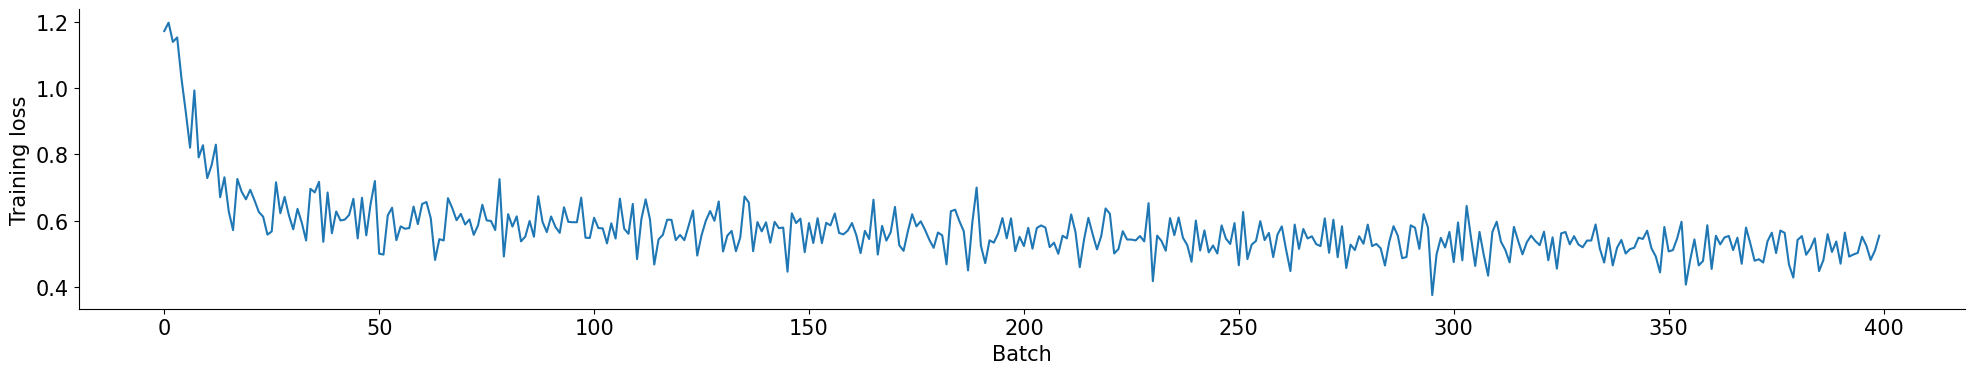

  0%|          | 0/100 [00:00<?, ?it/s]


Accuracy on the 256 training samples: 100.00
Accuracy on the 68 testing samples: 77.94



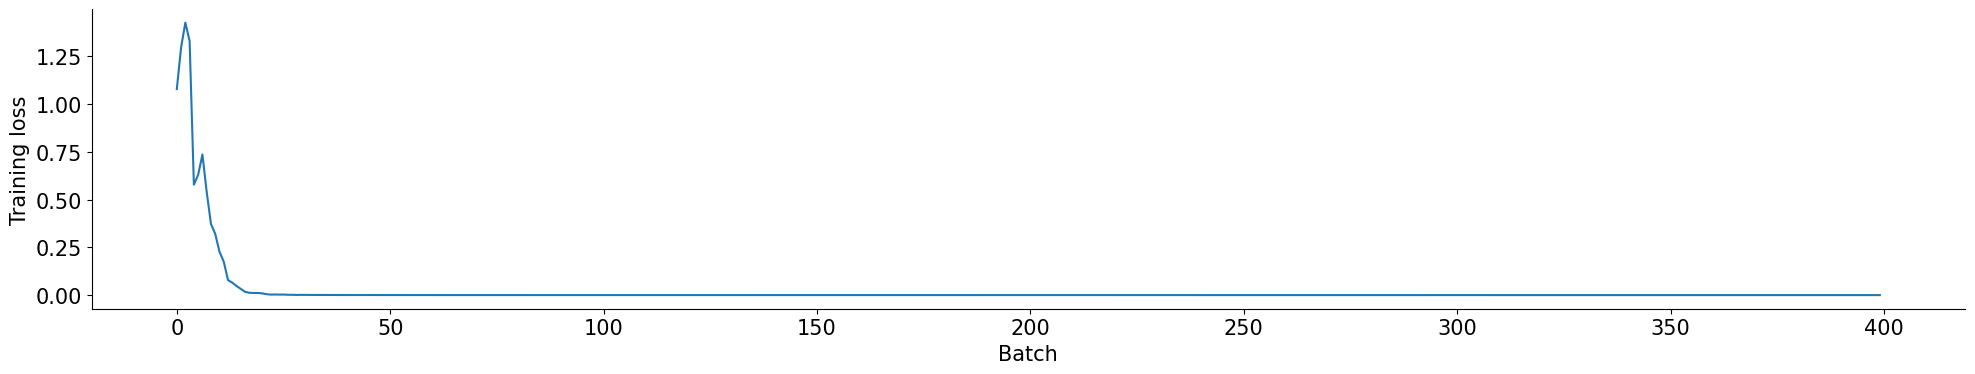

  0%|          | 0/100 [00:00<?, ?it/s]


Accuracy on the 256 training samples: 100.00
Accuracy on the 68 testing samples: 73.53



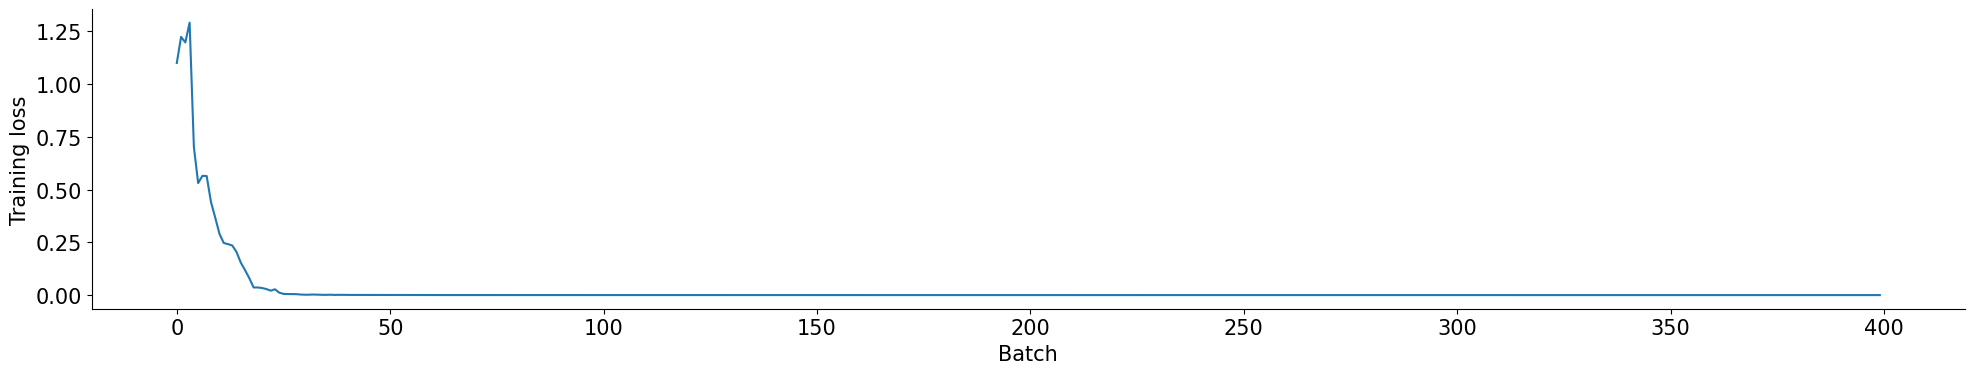

  0%|          | 0/100 [00:00<?, ?it/s]


Accuracy on the 256 training samples: 100.00
Accuracy on the 68 testing samples: 88.24



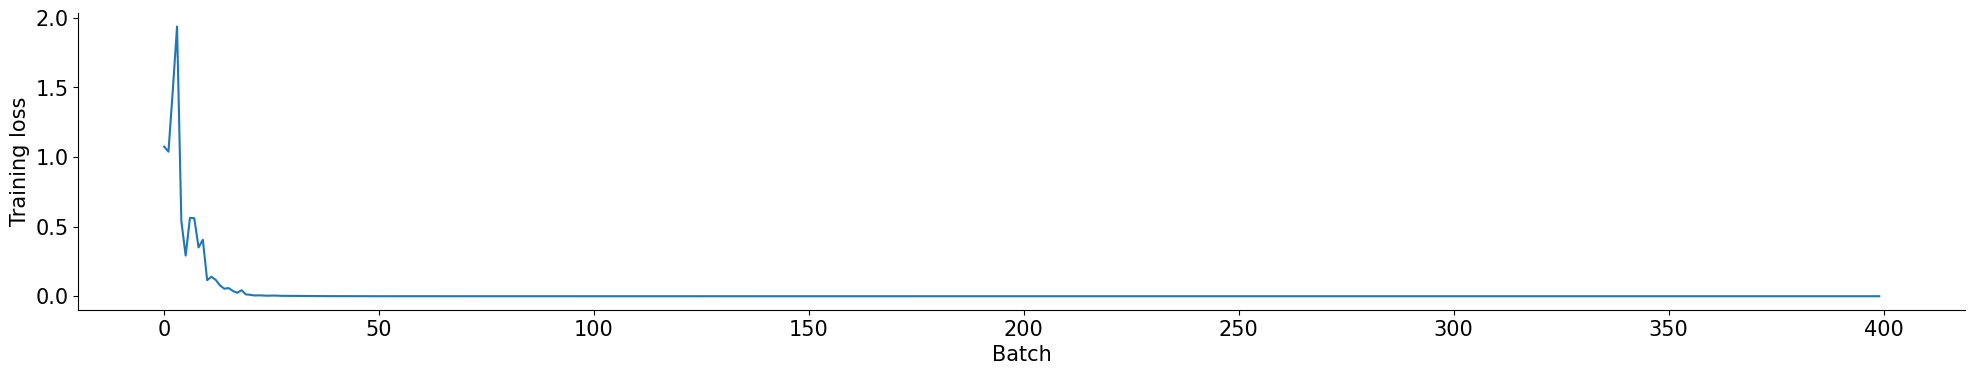

  0%|          | 0/100 [00:00<?, ?it/s]


Accuracy on the 256 training samples: 100.00
Accuracy on the 68 testing samples: 80.88



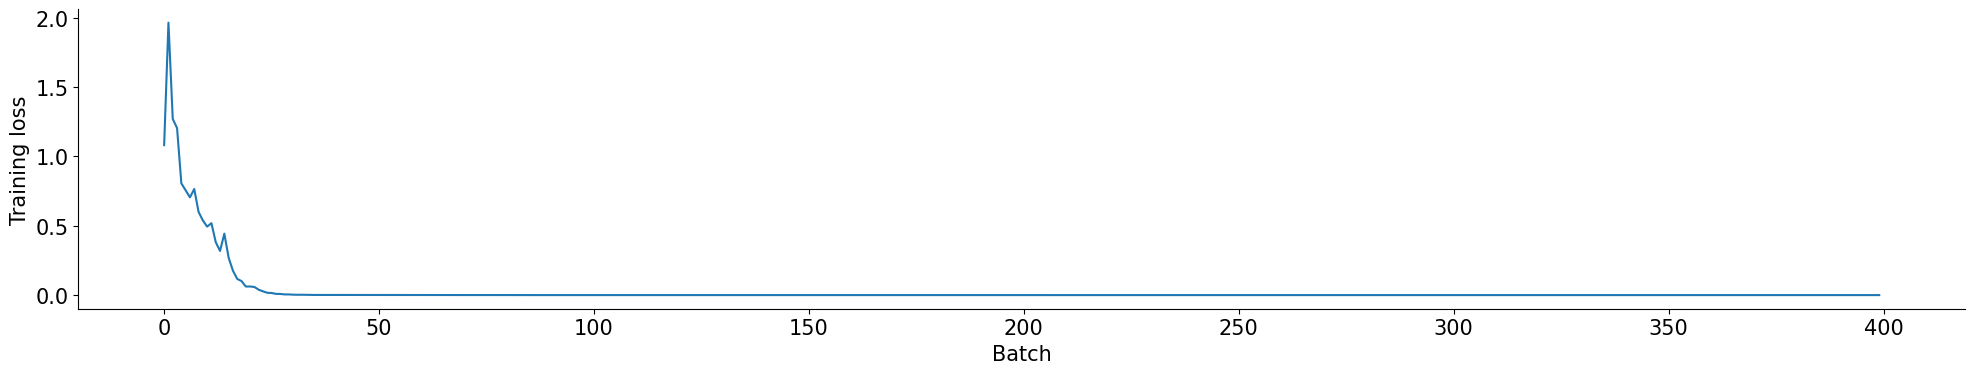

ValueError: ignored

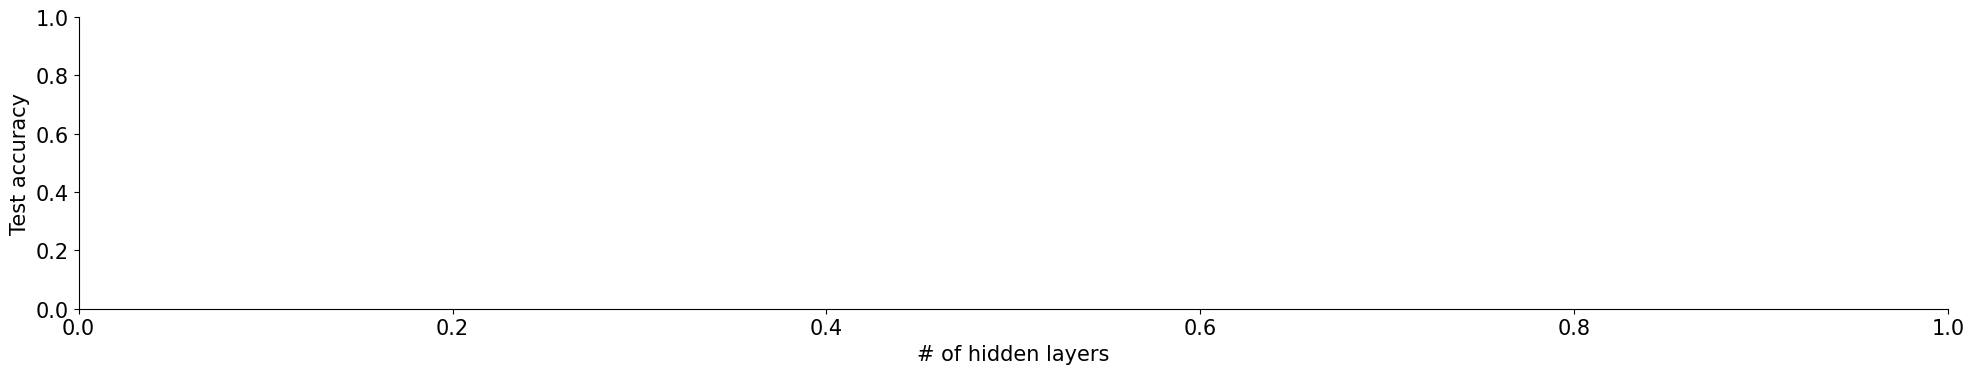

In [ ]:
def run_depth_optimizer(max_par_count, max_hidden_layer, device):
  """
  Simulate Depth Optimizer

  Args:
    max_par_count: int
      Maximum number of hidden units in layer of depth optimizer
    max_hidden_layer: int
      Maximum number of hidden layers within depth optimizer
    device: string
      CUDA/GPU if available, CPU otherwise

  Returns:
    hidden_layers: int
      Number of hidden layers in depth optimizer
    test_scores: list
      Log of test scores
  """
  ####################################################################
  # Fill in all missing code below (...),
  # then remove or comment the line below to test your function
  # raise NotImplementedError("Define the depth optimizer function")
  ###################################################################

  def count_parameters(model):
    """
    Function to count model parameters

    Args:
      model: instance of Net class
        MLP instance

    Returns:
      par_count: int
        Number of parameters in network
    """
    par_count = 0
    for p in model.parameters():
      if p.requires_grad:
        par_count += p.numel()
    return par_count

  # Number of hidden layers to try
    hidden_layers = 3

  # Test test score list
    test_scores = []

  # for hidden_layer in hidden_layers:
    # Initialize the hidden units in each hidden layer to be 1
    hidden_units = np.ones(hidden_layer, dtype=int)* 10

    # Define the the with hidden units equal to 1
    wide_net = Net('ReLU()', X_train.shape[0], hidden_units, 3).to(device)
    # par_count = count_parameters(wide_net)

    # Increment hidden_units and repeat until the par_count reaches the desired count
    # while par_count < max_par_count:
      # hidden_units += 1
    # wide_net = Net('ReLU()', X_train.shape[0], hidden_units, K).to(device)
      # par_count = count_parameters(wide_net)

    # Train it
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(wide_net.parameters(), lr=1e-3)
    _, test_acc = train_test_classification(wide_net, criterion, optimizer,
                                            train_loader, test_loader,
                                            num_epochs=100, device=device)
    test_scores += [test_acc]

    return test_scores



set_seed(seed=SEED)
max_par_count = 100
max_hidden_layer = 5
## Uncomment below to test your function
test_scores =[0]
for hidden_layer_ in [5, 10, 15, 20, 25]:
  wide_net = Net('ReLU()', X_train.shape[0], [hidden_layer_], 3).to(device)
  # hidden_layers, test_scores = run_depth_optimizer(max_par_count, max_hidden_layer, DEVICE)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(wide_net.parameters(), lr=1e-3)
  _, test_acc = train_test_classification(wide_net, criterion, optimizer,
                                              train_loader, test_loader,
                                              num_epochs=100, device=device)
  test_scores += [test_acc]
  plt.xlabel('# of hidden layers')
  plt.ylabel('Test accuracy')


plt.plot([5, 10, 15, 20, 25], test_scores)
plt.show()


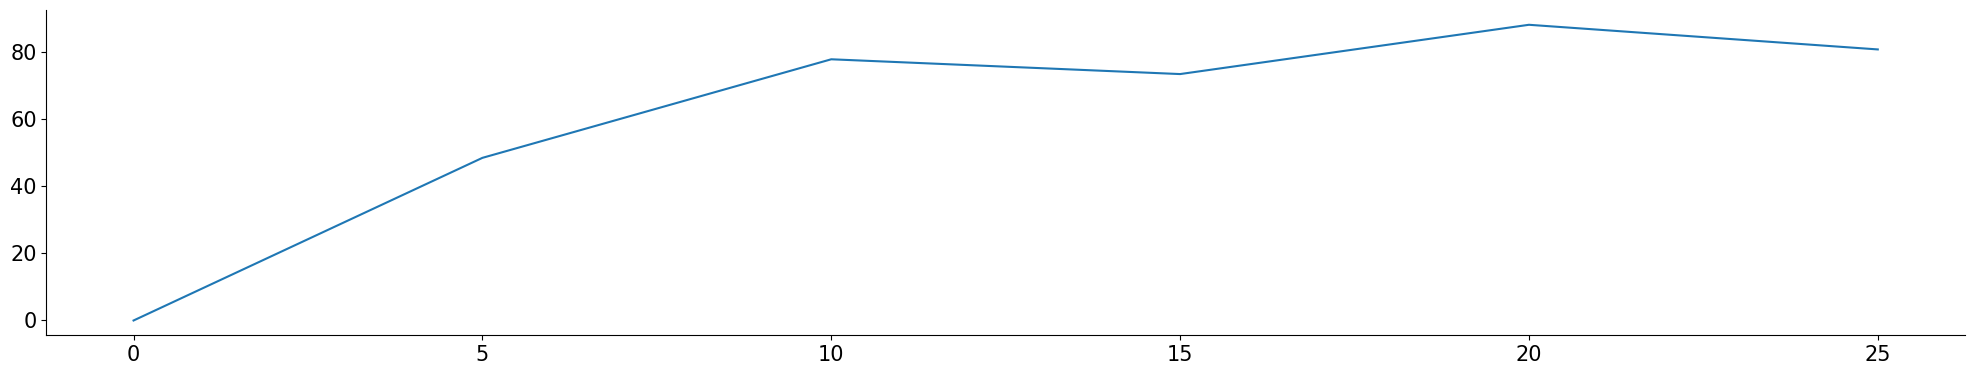

In [ ]:
plt.plot([0,5, 10, 15, 20, 25], test_scores)
plt.show()

In [ ]:
#############################################
#############################################
#############################################
# 1: We RNN to predict neural acitivity, and we could not make sense of it; i.e the output is firing rate, and comparision is against spike count; loss does not decay
# 2: We try MLP to predict responses from all neural data: as shown above
# 3: To do:
#         1. Find a way to see the hidden layder weights as shown in W1D5 Tutorial 1 Video 2: Case Study - MLP Classification;
#         2. Whether RNN can perform a better job? MLP needs to flatten the raster plots, so the input parameters is hugh: neurons (698) x timebins (250)
#         3. Instead of using responses as output, can we try out other behavior-related signals(reaction time, pupil size, ...) as output

In [ ]:
# @title Figure settings
from matplotlib import rcParams

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [ ]:
# @title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

In [ ]:
# @title Data loading
alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat,
                      np.load('steinmetz_part%d.npz'%j,
                              allow_pickle=True)['dat']))

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
device

device(type='cpu')

`alldat` contains 39 sessions from 10 mice, data from Steinmetz et al, 2019. Time bins for all measurements are 10ms, starting 500ms before stimulus onset. The mouse had to determine which side has the highest contrast. For each `dat = alldat[k]`, you have the fields below. For extra variables, check out the extra notebook and extra data files (lfp, waveforms and exact spike times, non-binned).

* `dat['mouse_name']`: mouse name
* `dat['date_exp']`: when a session was performed
* `dat['spks']`: neurons by trials by time bins.    
* `dat['brain_area']`: brain area for each neuron recorded.
* `dat['ccf']`: Allen Institute brain atlas coordinates for each neuron.
* `dat['ccf_axes']`: axes names for the Allen CCF.
* `dat['contrast_right']`: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
* `dat['contrast_left']`: contrast level for left stimulus.
* `dat['gocue']`: when the go cue sound was played.
* `dat['response_time']`: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.  
* `dat['response']`: which side the response was (`-1`, `0`, `1`). When the right-side stimulus had higher contrast, the correct choice was `-1`. `0` is a no go response.
* `dat['feedback_time']`: when feedback was provided.
* `dat['feedback_type']`: if the feedback was positive (`+1`, reward) or negative (`-1`, white noise burst).  
* `dat['wheel']`: turning speed of the wheel that the mice uses to make a response, sampled at `10ms`.
* `dat['pupil']`: pupil area  (noisy, because pupil is very small) + pupil horizontal and vertical position.
* `dat['face']`: average face motion energy from a video camera.
* `dat['licks']`: lick detections, 0 or 1.   
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons".
* `dat['%X%_passive']`: same as above for `X` = {`spks`, `pupil`, `wheel`, `contrast_left`, `contrast_right`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses.
* `dat['prev_reward']`: time of the feedback (reward/white noise) on the previous trial in relation to the current stimulus time.
* `dat['reaction_time']`: ntrials by 2. First column: reaction time computed from the wheel movement as the first sample above `5` ticks/10ms bin. Second column: direction of the wheel movement (`0` = no move detected).  


The original dataset is here: https://figshare.com/articles/dataset/Dataset_from_Steinmetz_et_al_2019/9598406

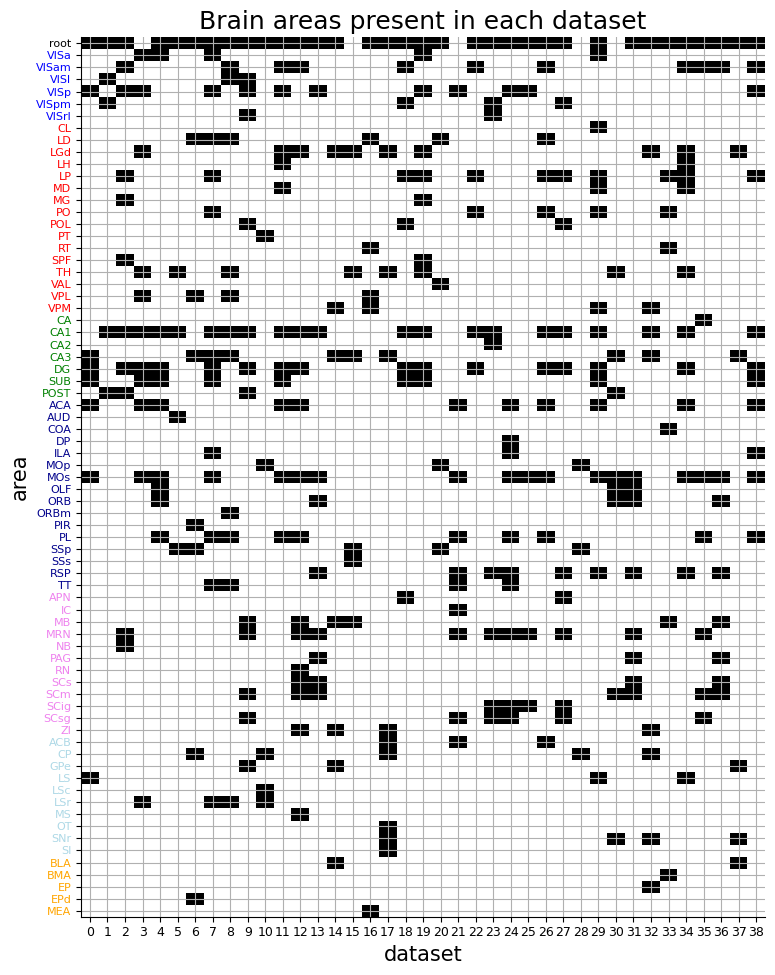

In [ ]:
# Make a plot of which brain areas are present in each dataset
# note that region 4 ("other ctx" are neurons that were not able to be classified)
# region 4 does not correspond to brain_group 4, which are all cortical neurons outside of visual cortex
regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
region_colors = ['blue', 'red', 'green', 'darkblue', 'violet', 'lightblue', 'orange', 'gray']
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"],  # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"],  # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP","TT"],  # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"],  # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"],  # basal ganglia
                ["BLA", "BMA", "EP", "EPd", "MEA"]  # cortical subplate
                ]

# Assign each area an index
area_to_index = dict(root=0)
counter = 1
for group in brain_groups:
    for area in group:
        area_to_index[area] = counter
        counter += 1

# Figure out which areas are in each dataset
areas_by_dataset = np.zeros((counter, len(alldat)), dtype=bool)
for j, d in enumerate(alldat):
    for area in np.unique(d['brain_area']):
        i = area_to_index[area]
        areas_by_dataset[i, j] = True

# Show the binary matrix
plt.figure(figsize=(8, 10))
plt.imshow(areas_by_dataset, cmap="Greys", aspect="auto", interpolation="none")

# Label the axes
plt.xlabel("dataset")
plt.ylabel("area")

# Add tick labels
yticklabels = ["root"]
for group in brain_groups:
  yticklabels.extend(group)
plt.yticks(np.arange(counter), yticklabels, fontsize=8)
plt.xticks(np.arange(len(alldat)), fontsize=9)

# Color the tick labels by region
ytickobjs = plt.gca().get_yticklabels()
ytickobjs[0].set_color("black")
counter = 1
for group, color in zip(brain_groups, region_colors):
  for area in group:
    ytickobjs[counter].set_color(color)
    counter += 1

plt.title("Brain areas present in each dataset")
plt.grid(True)
plt.show()

dict_keys(['spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive'])


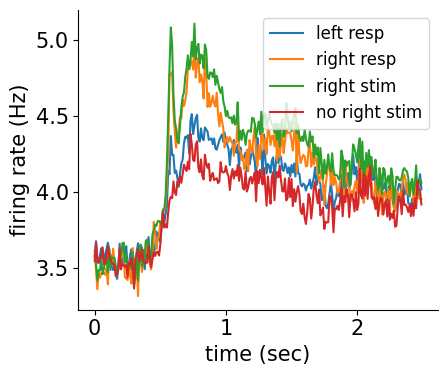

In [ ]:
# @title Basic plots of population average

# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx.
dat = alldat[11]
print(dat.keys())

dt = dat['bin_size']  # binning at 10 ms
NT = dat['spks'].shape[-1]

ax = plt.subplot(1, 5, 1)
response = dat['response']  # right - nogo - left (-1, 0, 1)
vis_right = dat['contrast_right']  # 0 - low - high
vis_left = dat['contrast_left']  # 0 - low - high
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:, response >= 0].mean(axis=(0, 1)))  # left responses
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:, response < 0].mean(axis=(0, 1)))  # right responses
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:, vis_right > 0].mean(axis=(0, 1)))  # stimulus on the right
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:, vis_right == 0].mean(axis=(0, 1)))  # no stimulus on the right

plt.legend(['left resp', 'right resp', 'right stim', 'no right stim'], fontsize=12)
ax.set(xlabel='time (sec)', ylabel='firing rate (Hz)')
plt.show()

In [ ]:
dat['spks'].shape
dat['response']

array([ 0.,  1.,  0.,  1., -1., -1., -1., -1.,  1., -1., -1., -1.,  1.,
        0., -1.,  0.,  1.,  1.,  1.,  1.,  1., -1.,  1., -1., -1.,  0.,
        1.,  1., -1.,  0.,  1., -1.,  0.,  0., -1., -1., -1.,  1.,  1.,
        1., -1.,  0.,  1., -1., -1.,  1.,  1., -1.,  1., -1., -1.,  1.,
       -1., -1., -1.,  1.,  1., -1., -1., -1.,  0.,  0., -1.,  1.,  0.,
       -1., -1.,  1.,  0.,  1.,  1.,  1.,  0.,  1.,  0.,  1., -1.,  1.,
       -1.,  1.,  1.,  1., -1.,  0.,  1., -1., -1.,  0.,  1.,  1., -1.,
        1., -1.,  1., -1., -1.,  0., -1.,  1.,  0., -1., -1., -1.,  1.,
        1., -1.,  0.,  1.,  1.,  1.,  1., -1.,  0.,  1., -1.,  1.,  0.,
        0., -1., -1., -1., -1.,  0.,  1.,  0.,  0.,  1., -1., -1.,  0.,
       -1., -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,  0.,  1., -1.,
       -1.,  1.,  1., -1.,  0., -1., -1.,  0.,  1.,  1.,  0.,  0.,  1.,
        0.,  1.,  1., -1.,  1., -1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,
       -1.,  1.,  1., -1., -1., -1.,  0., -1.,  1.,  0., -1., -1

In [ ]:
neurons = dat['spks']

In [ ]:
neurons = neurons.permute(2, 1, 0)

In [ ]:
neurons.shape

torch.Size([250, 340, 698])

In [ ]:
class Net(nn.Module):
  def __init__(self, ncomp, NN1, NN2, bidi=True):
    super(Net, self).__init__()

    # play with some of the options in the RNN!
    self.rnn = nn.RNN(NN1, ncomp, num_layers = 1, dropout = 0,
                      bidirectional = bidi, nonlinearity = 'tanh')
    self.fc = nn.Linear(ncomp, NN2)

  def forward(self, x):

    y = self.rnn(x)[0]

    if self.rnn.bidirectional:
      # if the rnn is bidirectional, it concatenates the activations from the forward and backward pass
      # we want to add them instead, so as to enforce the latents to match between the forward and backward pass
      q = (y[:, :, :ncomp] + y[:, :, ncomp:])/2
    else:
      q = y

    # the softplus function is just like a relu but it's smoothed out so we can't predict 0
    # if we predict 0 and there was a spike, that's an instant Inf in the Poisson log-likelihood which leads to failure
    z = F.softplus(self.fc(q), 10)

    return z, q



In [ ]:
x = dat['spks'].T

In [ ]:
dat['brain_area']

array(['VISp', 'VISp', 'VISp', 'DG', 'VISp', 'VISp', 'SUB', 'DG', 'VISp',
       'VISp', 'SUB', 'DG', 'VISp', 'VISp', 'SUB', 'VISp', 'VISp', 'VISp',
       'SUB', 'SUB', 'DG', 'VISp', 'SUB', 'VISp', 'VISp', 'VISp', 'DG',
       'VISp', 'SUB', 'SUB', 'SUB', 'SUB', 'SUB', 'SUB', 'SUB', 'VISp',
       'VISp', 'SUB', 'VISp', 'DG', 'SUB', 'VISp', 'DG', 'SUB', 'SUB',
       'LGd', 'SUB', 'VISp', 'VISp', 'SUB', 'SUB', 'VISp', 'SUB', 'SUB',
       'DG', 'VISp', 'SUB', 'DG', 'VISp', 'VISp', 'SUB', 'VISp', 'LGd',
       'VISp', 'DG', 'SUB', 'SUB', 'DG', 'SUB', 'DG', 'VISp', 'LGd',
       'SUB', 'SUB', 'DG', 'SUB', 'SUB', 'SUB', 'DG', 'LGd', 'SUB', 'SUB',
       'SUB', 'SUB', 'SUB', 'SUB', 'SUB', 'DG', 'VISp', 'VISp', 'SUB',
       'SUB', 'SUB', 'VISp', 'SUB', 'VISp', 'DG', 'SUB', 'SUB', 'SUB',
       'VISp', 'SUB', 'SUB', 'SUB', 'DG', 'SUB', 'VISp', 'DG', 'SUB',
       'VISp', 'VISp', 'SUB', 'SUB', 'SUB', 'SUB', 'SUB', 'SUB', 'SUB',
       'VISp', 'SUB', 'VISp', 'VISp', 'VISp', 'VISp', 'SUB', 'S

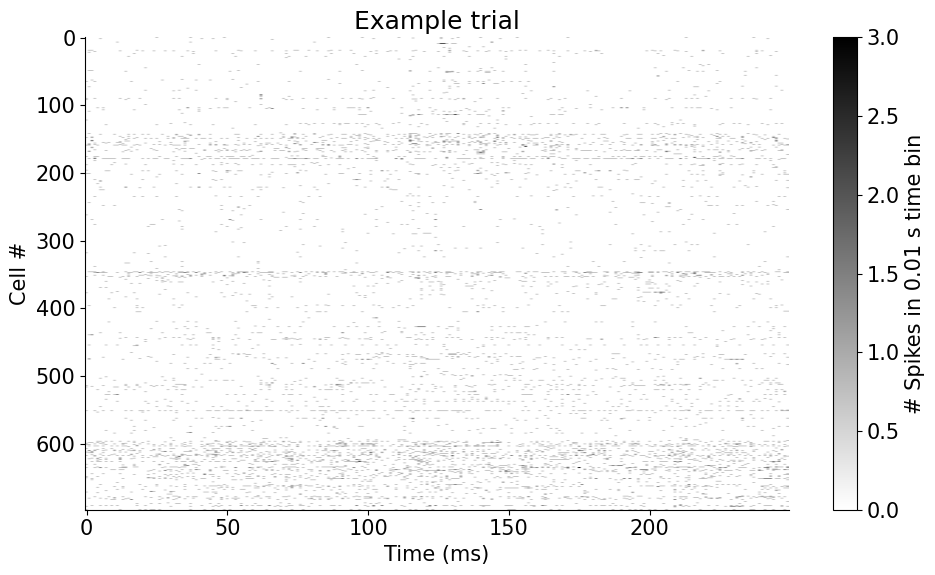

In [ ]:
plt.figure(figsize = (10, 6))
plt.imshow(x[:, 2, :].T, cmap='gray_r', vmax = 3, vmin=0, aspect='auto')
plt.xlabel('Time (ms)')
plt.ylabel('Cell #')
plt.colorbar(orientation='vertical', label='# Spikes in 0.01 s time bin')
plt.title('Example trial')
plt.show()

# MLP: flatten data --> classifier
# can RNN work similarly?
%%

In [ ]:
# we separate the neuron data into two populations: the input and output
x0 = torch.from_numpy(x[:, :, :200]).to(device).float()
x1 = torch.from_numpy(x[:, :, 200:400]).to(device).float()

NN1 = x1.shape[-1]
NN2 = x0.shape[-1]

# we initialize the neural network
ncomp = 10
net = Net(ncomp, NN1, NN2, bidi = True).to(device)

# special thing:  we initialize the biases of the last layer in the neural network
# we set them as the mean firing rates of the neurons.
# this should make the initial predictions close to the mean, because the latents don't contribute much
net.fc.bias.data[:] = x1.mean((0,1))

# we set up the optimizer. Adjust the learning rate if the training is slow or if it explodes.
optimizer = torch.optim.Adam(net.parameters(), lr=.005)

In [ ]:
# you can keep re-running this cell if you think the cost might decrease further

# we define the Poisson log-likelihood loss
def Poisson_loss(lam, spk):
  return lam - spk * torch.log(lam)

niter = 101
for k in range(niter):
  # the network outputs the single-neuron prediction and the latents
  z, y = net(x1)

  # our log-likelihood cost
  cost = Poisson_loss(z, x0).mean()

  # train the network as usual
  cost.backward()
  optimizer.step()
  optimizer.zero_grad()

  if k % 100 == 0:
    print(f'iteration {k}, cost {cost.item():.4f}')

iteration 0, cost 0.1140
iteration 100, cost 0.1128


In [ ]:
rpred = z.detach().cpu().numpy()

nn = 29
plt.figure(figsize=(10, 6))
plt.plot(rates[:,nn, 0])
plt.plot(rpred[:,nn, 0])
plt.plot(-.5 + x[:, nn, 0]/4)

plt.legend(['rates (true)', 'rates (predicted)', 'spikes'])
plt.title(f'Neuron {nn}')
plt.show()

In [ ]:
nareas = 4  # only the top 4 regions are in this particular mouse
NN = len(dat['brain_area'])  # number of neurons
barea = nareas * np.ones(NN, )  # last one is "other"
for j in range(nareas):
  barea[np.isin(dat['brain_area'], brain_groups[j])] = j  # assign a number to each region

In [ ]:
regions

['vis ctx',
 'thal',
 'hipp',
 'other ctx',
 'midbrain',
 'basal ganglia',
 'cortical subplate',
 'other']

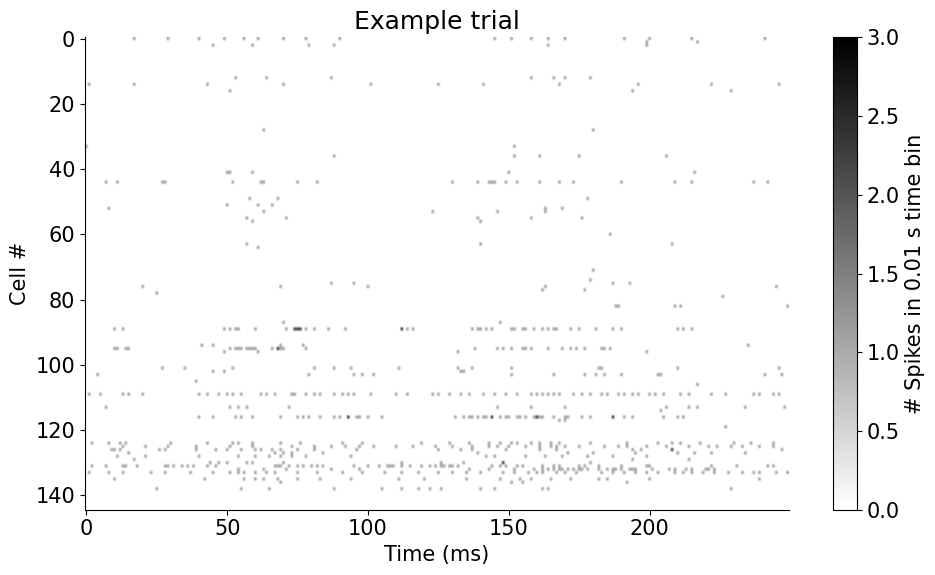

In [ ]:
plt.figure(figsize = (10, 6))
plt.imshow(dat['spks'][barea==0][:,1,:], cmap='gray_r', vmax = 3, vmin=0, aspect='auto')
plt.xlabel('Time (ms)')
plt.ylabel('Cell #')
plt.colorbar(orientation='vertical', label='# Spikes in 0.01 s time bin')
plt.title('Example trial')
plt.show()

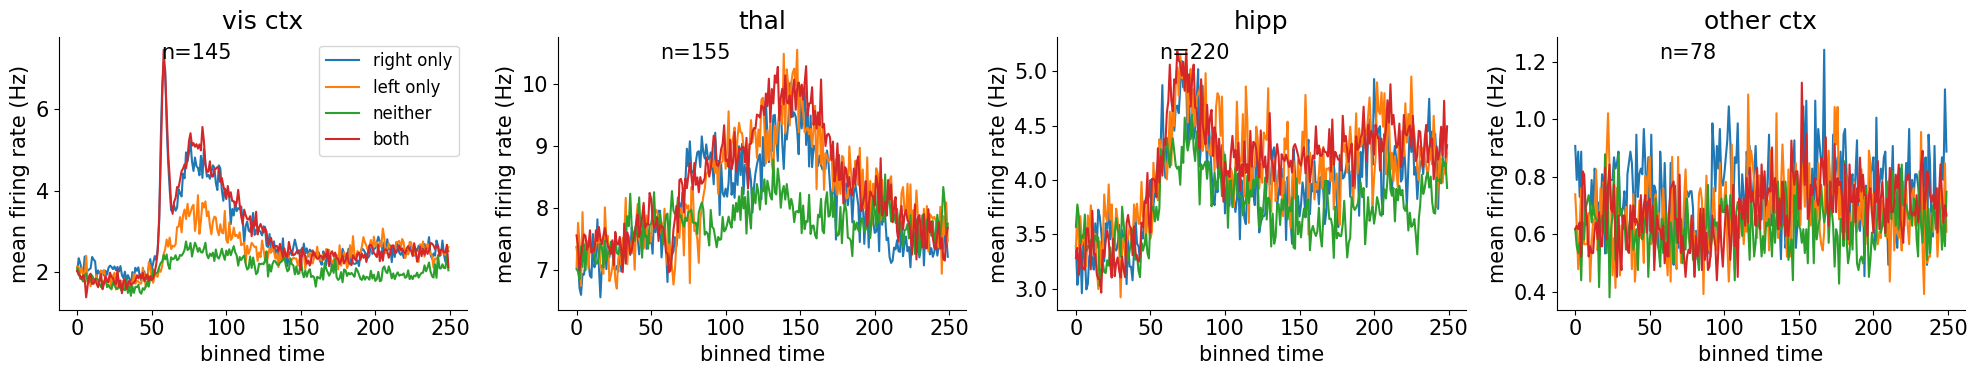

In [ ]:
# @title plots by brain region and visual conditions
for j in range(nareas):
  ax = plt.subplot(1, nareas, j + 1)

  plt.plot(1/dt * dat['spks'][barea==j][:, np.logical_and(vis_left == 0, vis_right > 0)].mean(axis=(0, 1)))
  plt.plot(1/dt * dat['spks'][barea==j][:, np.logical_and(vis_left > 0, vis_right == 0)].mean(axis=(0, 1)))
  plt.plot(1/dt * dat['spks'][barea==j][:, np.logical_and(vis_left == 0, vis_right == 0)].mean(axis=(0, 1)))
  plt.plot(1/dt * dat['spks'][barea==j][:, np.logical_and(vis_left > 0, vis_right > 0)].mean(axis=(0, 1)))
  plt.text(.25, .92, 'n=%d'%np.sum(barea == j), transform=ax.transAxes)

  if j==0:
    plt.legend(['right only', 'left only', 'neither', 'both'], fontsize=12)
  ax.set(xlabel='binned time', ylabel='mean firing rate (Hz)', title=regions[j])
plt.show()

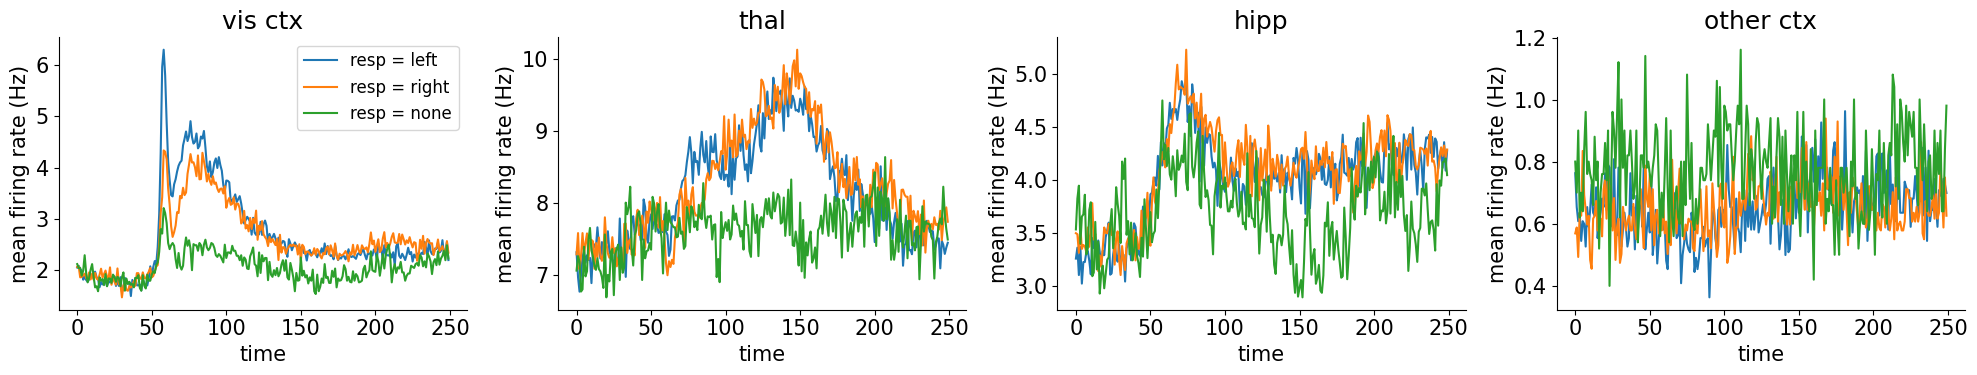

In [ ]:
# @title plots by brain region and response type
for j in range(nareas):
  ax = plt.subplot(1, nareas, j + 1)
  plt.title(regions[j])
  if np.sum(barea == j) == 0:
    continue
  plt.plot(1/dt * dat['spks'][barea == j][:, response < 0].mean(axis=(0, 1)))
  plt.plot(1/dt * dat['spks'][barea == j][:, response > 0].mean(axis=(0, 1)))
  plt.plot(1/dt * dat['spks'][barea == j][:, response == 0].mean(axis=(0, 1)))

  if j == 0:
    plt.legend(['resp = left', 'resp = right', 'resp = none'], fontsize=12)
  ax.set(xlabel='time', ylabel='mean firing rate (Hz)')
plt.show()

In [ ]:
# @title top PC directions from stimulus + response period, with projections of the entire duration

droll = np.reshape(dat['spks'][:, :, 51:130], (NN, -1))  # first 80 bins = 1.6 sec
droll = droll - np.mean(droll, axis=1)[:, np.newaxis]
model = PCA(n_components=5).fit(droll.T)
W = model.components_
pc_10ms = W @ np.reshape(dat['spks'], (NN, -1))
pc_10ms = np.reshape(pc_10ms, (5, -1, NT))

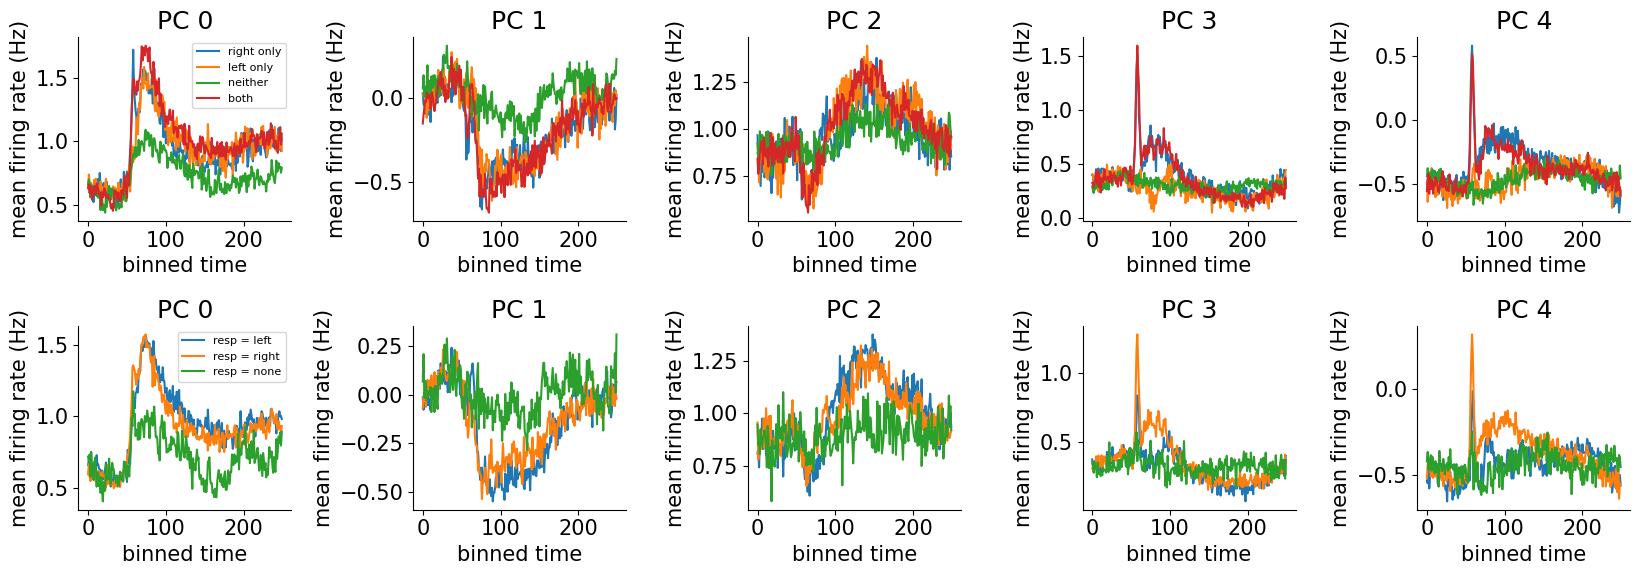

In [ ]:
# @title The top PCs capture most variance across the brain. What do they care about?
plt.figure(figsize= (20, 6))
for j in range(len(pc_10ms)):
  ax = plt.subplot(2, len(pc_10ms) + 1, j + 1)
  pc1 = pc_10ms[j]

  plt.plot(pc1[np.logical_and(vis_left == 0, vis_right > 0), :].mean(axis=0))
  plt.plot(pc1[np.logical_and(vis_left > 0, vis_right == 0), :].mean(axis=0))
  plt.plot(pc1[np.logical_and(vis_left == 0, vis_right == 0), :].mean(axis=0))
  plt.plot(pc1[np.logical_and(vis_left > 0, vis_right > 0), :].mean(axis=0))

  if j == 0:
    plt.legend(['right only', 'left only', 'neither', 'both'], fontsize=8)
  ax.set(xlabel = 'binned time', ylabel='mean firing rate (Hz)')
  plt.title('PC %d'%j)

  ax = plt.subplot(2, len(pc_10ms) + 1, len(pc_10ms) + 1 + j + 1)

  plt.plot(pc1[response > 0, :].mean(axis=0))
  plt.plot(pc1[response < 0, :].mean(axis=0))
  plt.plot(pc1[response == 0, :].mean(axis=0))

  if j == 0:
    plt.legend(['resp = left', 'resp = right', 'resp = none'], fontsize=8)
  ax.set(xlabel='binned time', ylabel='mean firing rate (Hz)')
  plt.title('PC %d'%j)
plt.show()

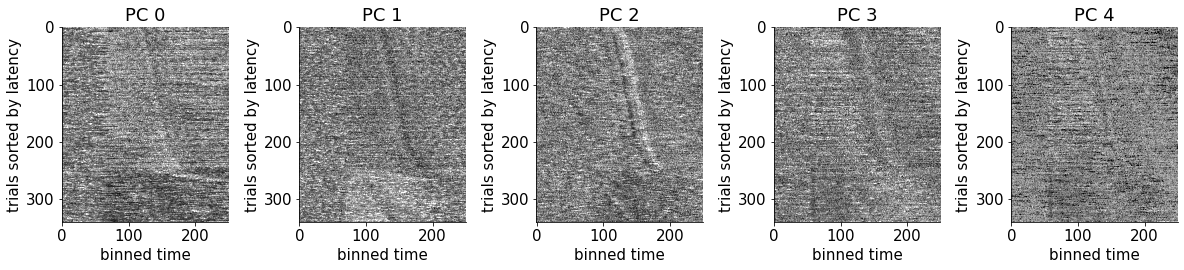

In [ ]:
# @title now sort all trials by response latency and see if the PCs care about that.
isort = np.argsort(dat['response_time'].flatten())

for j in range(len(pc_10ms)):
  ax = plt.subplot(1, len(pc_10ms) + 1, j + 1)
  pc1 = zscore(pc_10ms[j])
  plt.imshow(pc1[isort, :], aspect='auto', vmax=2, vmin=-2, cmap='gray')
  ax.set(xlabel='binned time', ylabel='trials sorted by latency')
  plt.title('PC %d'%j)
plt.show()

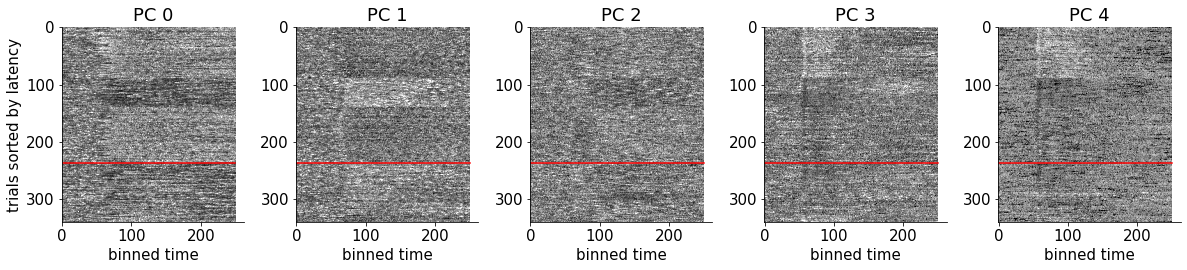

In [ ]:
# @title correct vs incorrect trials
# the following are the correct responses:
# if vis_left > vis_right : response >0
# if vis_left < vis_right : response <0
# if vis_left = vis_right : response =0
# trials below red line are incorrect
is_correct = np.sign(response) == np.sign(vis_left - vis_right)

# sort by correct, and then by response
isort = np.argsort(-is_correct.astype('float32') + response/10)

nwrong = np.sum(is_correct)
for j in range(len(pc_10ms)):
  ax = plt.subplot(1, len(pc_10ms) + 1, j + 1)
  pc1 = zscore(pc_10ms[j])
  plt.imshow(pc1[isort, :], aspect='auto', vmax=2, vmin=-2, cmap='gray')
  ax.set(xlabel='binned time')
  if j == 0:
    ax.set(ylabel='trials sorted by latency')
  plt.title('PC %d'%j)

  plt.plot([0, NT], [nwrong, nwrong], 'r')
plt.show()

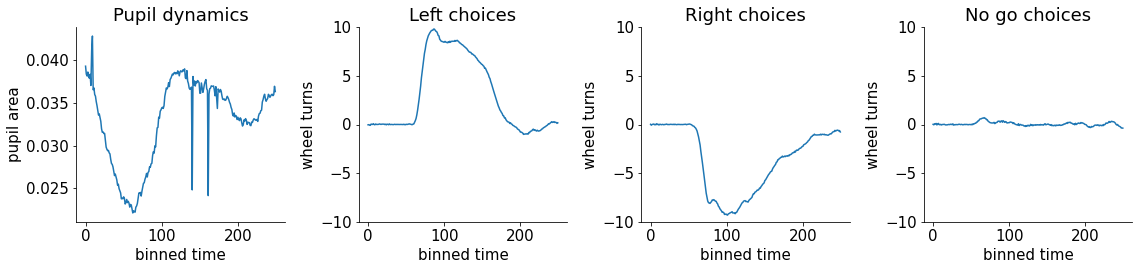

In [ ]:
# plot the behavioral data (pupil area is noisy because it's very small)

ax = plt.subplot(1, 5, 1)
plt.plot(dat['pupil'][0, :].mean(0));
ax.set(ylabel='pupil area', xlabel='binned time', title='Pupil dynamics')

yl = [-10, 10]
ax = plt.subplot(1, 5, 2)
plt.plot(dat['wheel'][0, response > 0].mean(0))
ax.set(ylim=yl)
ax.set(ylim=yl, ylabel='wheel turns', xlabel='binned time', title='Left choices')

ax = plt.subplot(1, 5, 3)
plt.plot(dat['wheel'][0, response<0].mean(0))
ax.set(ylim=yl)
ax.set(ylim=yl, ylabel='wheel turns', xlabel='binned time', title='Right choices')

ax = plt.subplot(1, 5, 4)
plt.plot(dat['wheel'][0, response==0].mean(0))
ax.set(ylim=yl, ylabel='wheel turns', xlabel='binned time', title='No go choices')
plt.show()

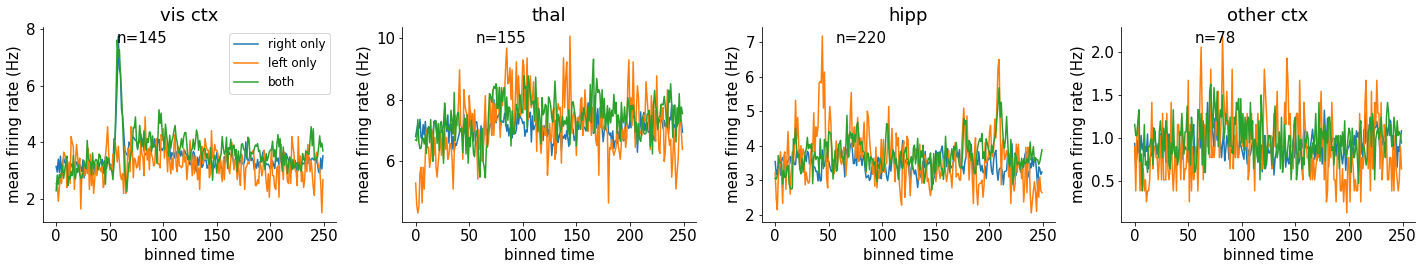

In [ ]:
# plots by brain region and visual conditions for PASSIVE trials
vis_left_p = dat['contrast_left_passive']
vis_right_p = dat['contrast_right_passive']
for j in range(nareas):
  ax = plt.subplot(1, nareas, j + 1)
  plt.title(regions[j])

  plt.plot(1/dt * dat['spks_passive'][barea == j][:, np.logical_and(vis_left_p == 0, vis_right_p > 0)].mean(axis=(0, 1)))
  plt.plot(1/dt * dat['spks_passive'][barea == j][:, np.logical_and(vis_left_p > 0, vis_right_p == 0)].mean(axis=(0, 1)))
  #plt.plot(1/dt *  dat['spks_passive'][barea == j][:, np.logical_and(vis_left_p == 0, vis_right_p == 0)].mean(axis=(0, 1)))
  plt.plot(1/dt * dat['spks_passive'][barea == j][:, np.logical_and(vis_left_p > 0, vis_right_p > 0)].mean(axis=(0, 1)))
  plt.text(.25, .92, 'n=%d'%np.sum(barea == j), transform=ax.transAxes)

  if j == 0:
    plt.legend(['right only', 'left only', 'both'], fontsize=12)
  ax.set(xlabel='binned time', ylabel='mean firing rate (Hz)')
plt.show()

In [ ]:
# for more variables check out the additional notebook (load_steinmetz_extra) which includes LFP, waveform shapes and exact spike times (non-binned)